In [63]:
from influxdb_client import InfluxDBClient

import pandas as pd

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Get data

In [173]:
df = pd.read_csv("dataframe.csv")
df.time = pd.to_datetime(df.time, dayfirst = True)
df.set_index('time',inplace=True)
points_per_day = 288 
df.tail()

,temperature,humidity,pressure,people
time,,,,
2020-07-15 12:10:00+00:00,28.65,38.00,1016.5,0.0
2020-07-15 12:15:00+00:00,28.65,38.00,1016.5,0.0
2020-07-15 12:20:00+00:00,28.70,38.30,1016.5,0.0
2020-07-15 12:25:00+00:00,28.65,38.45,1016.5,0.0
2020-07-15 12:30:00+00:00,28.75,38.70,1016.5,0.0


## Get the d param

In [149]:
from pmdarima.arima import ndiffs
kpss_diff = ndiffs(df['temperature'].values, alpha=0.05, test='kpss', max_d=12)
adf_diff = ndiffs(df['temperature'].values, alpha=0.05, test='adf', max_d=12)
n_diffs = max(adf_diff , kpss_diff )
n_diffs

1

## Visualize the period

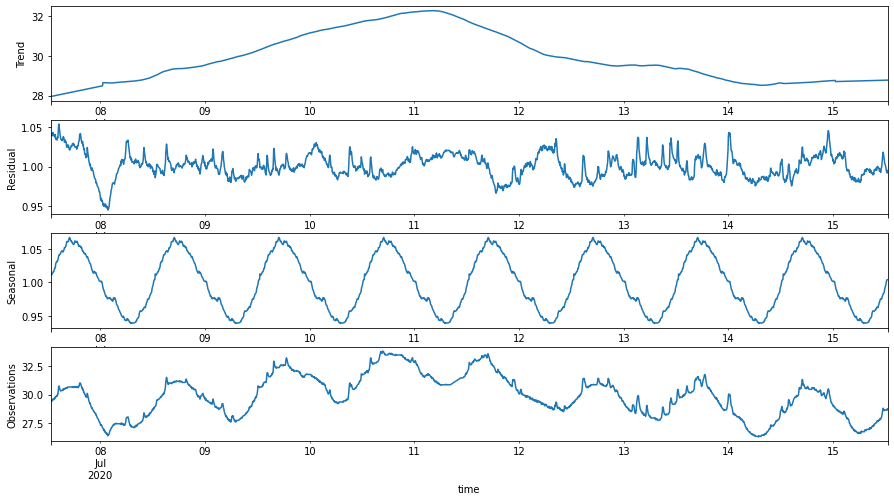

In [150]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df['temperature'], model='multiplicative', 
                            extrapolate_trend='freq',
                                         period=288) #additive or multiplicative is data specific

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))

ax1.set_ylabel('Trend')
ax2.set_ylabel('Residual')
ax3.set_ylabel('Seasonal')
ax4.set_ylabel('Observations')

decomposition.trend.plot(ax=ax1)
decomposition.resid.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
decomposition.observed.plot(ax=ax4)
plt.show()


## Split the dataset

In [151]:
# divide in train e test
size = len(df)- (points_per_day*1)
# size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

## Augmented Dickey-Fuller Test (ADF Test) 

In [152]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [153]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2224
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0187. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "humidity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7998
 No. Lags Chosen       = 4
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.3806. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "pressure" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. No

## Force stationarity

In [156]:
df_differenced = df_train.diff().dropna()

In [157]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0693
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "humidity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.9483
 No. Lags Chosen       = 3
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pressure" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance

## Create the VAR Model 

In [159]:
model = VAR(df_differenced)
x = model.select_order(maxlags=100)
x.summary()

,AIC,BIC,FPE,HQIC
0,-13.45,-13.44,1.445e-06,-13.44
1,-14.04,-13.99,7.950e-07,-14.02
2,-14.31,-14.21,6.069e-07,-14.28
3,-14.34,-14.19,5.930e-07,-14.28
4,-14.42,-14.22*,5.464e-07,-14.35*
5,-14.42,-14.17,5.484e-07,-14.33
6,-14.43,-14.14,5.404e-07,-14.32
7,-14.43,-14.10,5.394e-07,-14.31
8,-14.44*,-14.06,5.358e-07*,-14.30
9,-14.43,-14.00,5.428e-07,-14.27


In [160]:
aic = []
bic = []
fpe = []
hqic = []

model = VAR(df_differenced)
for i in range(1,20):
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
   # print('Lag Order =', i)
   # print('AIC : ', result.aic)
   # print('BIC : ', result.bic)
   # print('FPE : ', result.fpe)
   # print('HQIC: ', result.hqic, '\n')

In [162]:
res_train = pd.DataFrame(data=aic, columns=["aic"])
res_train["bic"] = bic 
res_train["fpe"] = fpe
res_train["fpe"] = 10000000*res_train["fpe"]
res_train["hqic"] = hqic
res_train.index += 1 

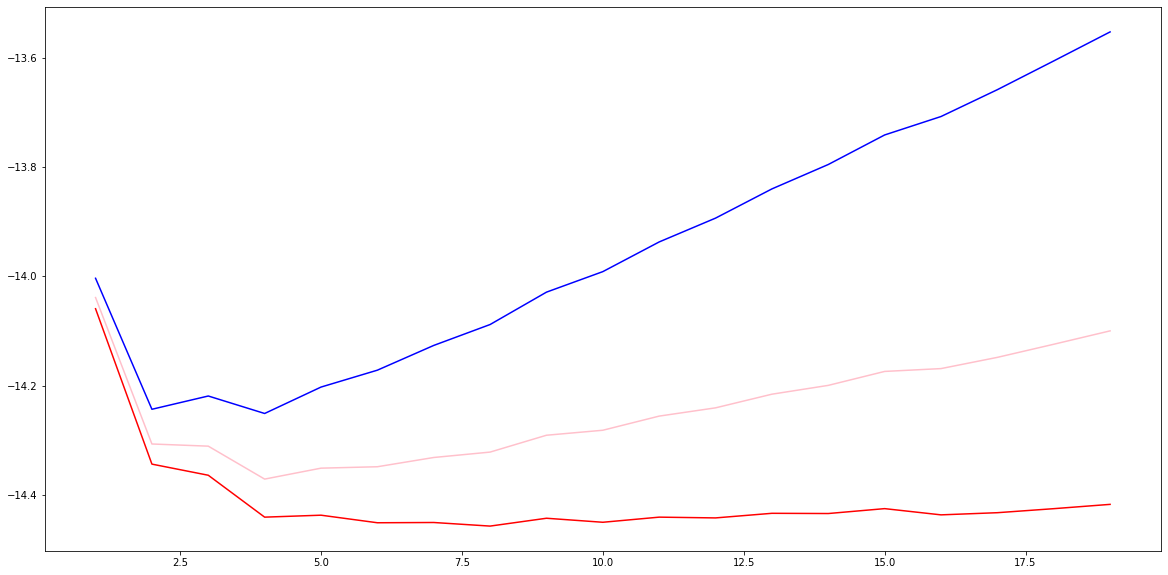

In [163]:
res_train.aic.plot(figsize = (20,10), color = "red")
res_train.bic.plot(color = "blue")
#res_train.fpe.plot(color = "green")
res_train.hqic.plot(color = "pink")
plt.show()

## Train the model

In [165]:
# model_fitted = model.fit(4)
# model_fitted.summary()

#model_fitted = model.fit(maxlags=8, ic='aic')
model_fitted = model.fit(maxlags=8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Jul, 2020
Time:                     17:20:09
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -14.0880
Nobs:                     2007.00    HQIC:                  -14.3213
Log likelihood:           3247.98    FPE:                5.26716e-07
AIC:                     -14.4566    Det(Omega_mle):     4.93453e-07
--------------------------------------------------------------------
Results for equation temperature
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.000274         0.002063           -0.133           0.894
L1.temperature         0.318097         0.022704           14.010           0.000
L1.humidity            0.047903         0.013757  

## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [166]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

temperature : 2.0
humidity : 2.0
pressure : 2.0
people : 2.0


## Forecast VAR model 

In [167]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

8


array([[ 0.35      , -0.2       , -0.52      ,  0.        ],
       [ 0.1       , -0.65      ,  0.5       ,  0.        ],
       [ 0.        ,  0.15      ,  0.16666667,  0.        ],
       [ 0.2       ,  0.        , -0.33333333,  0.        ],
       [ 0.15      , -0.2       ,  0.16666667,  0.        ],
       [-0.15      , -0.2       ,  0.        ,  0.        ],
       [-0.1       ,  0.1       , -1.        ,  0.        ],
       [-0.2       ,  0.1       ,  0.        ,  0.        ]])

In [168]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=12)
df_forecast = pd.DataFrame(fc, index=df.index[-12:], columns=df.columns + '_1d')
df_forecast

,temperature_1d,humidity_1d,pressure_1d,people_1d
time,,,,
2020-07-15 11:35:00+00:00,-0.080156,0.224473,-0.057957,-0.008912
2020-07-15 11:40:00+00:00,-0.035761,0.159285,-0.032165,-0.127164
2020-07-15 11:45:00+00:00,-0.006495,0.093497,0.044314,0.028306
2020-07-15 11:50:00+00:00,0.000963,0.048144,-0.039244,0.158356
2020-07-15 11:55:00+00:00,0.027311,-0.004607,0.059787,-0.053508
2020-07-15 12:00:00+00:00,0.046697,0.010852,0.036642,-0.001010
2020-07-15 12:05:00+00:00,0.025139,0.006767,-0.036246,0.072975
2020-07-15 12:10:00+00:00,0.016253,-0.016853,0.014922,-0.012298
2020-07-15 12:15:00+00:00,0.006655,-0.013863,-0.001434,-0.025588


## Invert the transformation to get the real forecast

In [143]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [169]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)  
df_results.loc[:, ['temperature_forecast', 'humidity_forecast', 'pressure_forecast', 'people_forecast']]
#df_results.loc[:, ['temperature_forecast', 'humidity_forecast', 'pressure_forecast']]

,temperature_forecast,humidity_forecast,pressure_forecast,people_forecast
time,,,,
2020-07-15 11:35:00+00:00,28.419844,39.724473,1017.442043,-0.008912
2020-07-15 11:40:00+00:00,28.384082,39.883758,1017.409878,-0.136076
2020-07-15 11:45:00+00:00,28.377588,39.977255,1017.454192,-0.107770
2020-07-15 11:50:00+00:00,28.378551,40.025399,1017.414948,0.050586
2020-07-15 11:55:00+00:00,28.405862,40.020792,1017.474735,-0.002922
2020-07-15 12:00:00+00:00,28.452559,40.031644,1017.511377,-0.003932
2020-07-15 12:05:00+00:00,28.477698,40.038412,1017.475131,0.069043
2020-07-15 12:10:00+00:00,28.493951,40.021558,1017.490054,0.056746
2020-07-15 12:15:00+00:00,28.500605,40.007695,1017.488619,0.031158


## Plot of Forecast vs Actuals

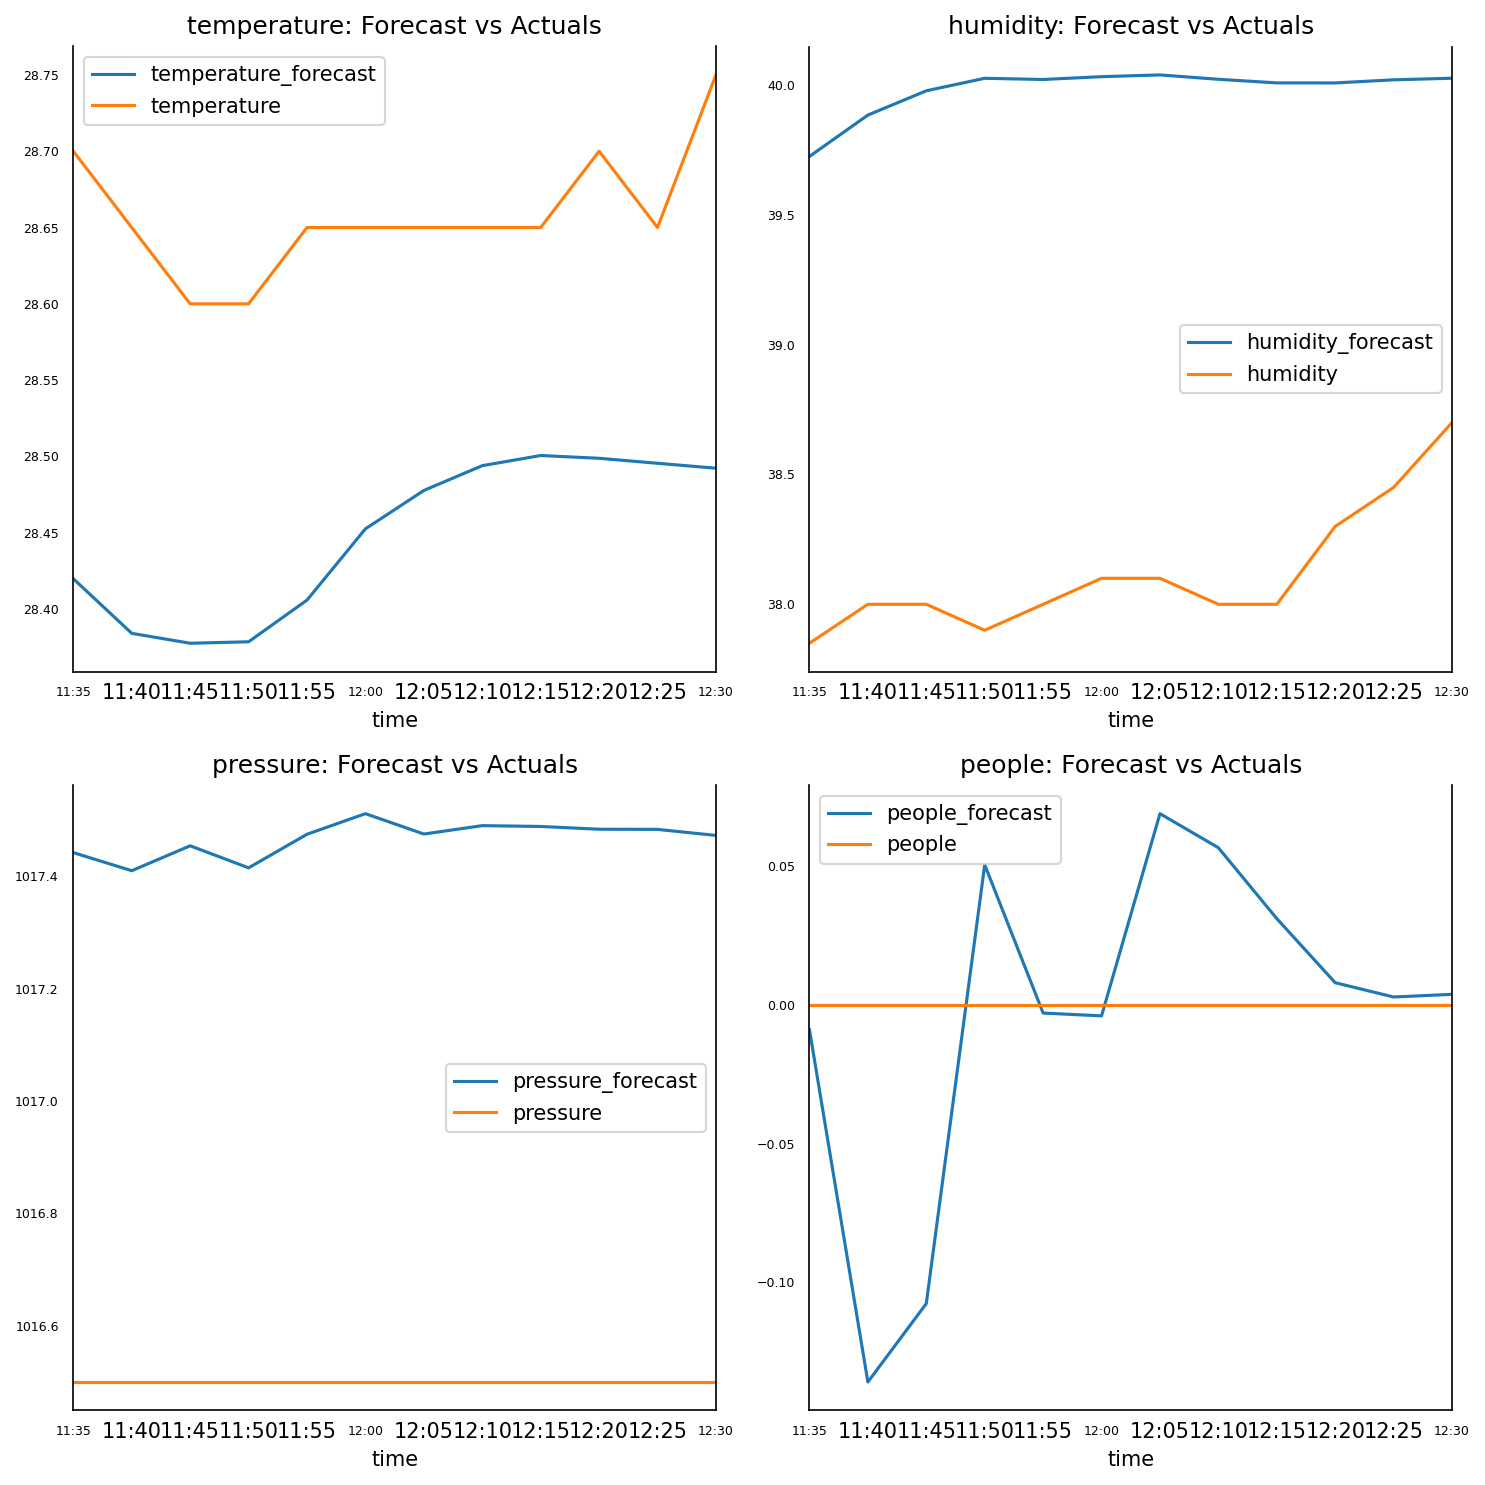

In [170]:
nobs=12
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [171]:
import numpy as np
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = (mean_squared_error(forecast, actual))
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: temperature')
accuracy_prod = forecast_accuracy(df_results['temperature_forecast'].values, df_test['temperature'][:12])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: humidity')
accuracy_prod = forecast_accuracy(df_results['humidity_forecast'].values, df_test['humidity'][:12])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: pressure')
accuracy_prod = forecast_accuracy(df_results['pressure_forecast'].values, df_test['pressure'][:12])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: people')
accuracy_prod = forecast_accuracy(df_results['people_forecast'].values, df_test['people'][:12])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))


Forecast Accuracy of: temperature
mape :  0.0036
me :  -0.1019
mae :  0.1029
mpe :  -0.0036
mse :  0.0197
rmse :  0.1404
corr :  0.6967
minmax :  0.0036

Forecast Accuracy of: humidity
mape :  0.0221
me :  -0.8472
mae :  0.9114
mpe :  -0.0205
mse :  1.0878
rmse :  1.043
corr :  0.7724
minmax :  0.0221

Forecast Accuracy of: pressure
mape :  0.0
me :  -0.0333
mae :  0.0352
mpe :  -0.0
mse :  0.002
rmse :  0.0445
corr :  nan
minmax :  0.0

Forecast Accuracy of: people
mape :  inf
me :  -0.0031
mae :  0.0402
mpe :  nan
mse :  0.0035
rmse :  0.059
corr :  nan
minmax :  inf


/home/adamf42/anaconda3/envs/forecasting_service/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/adamf42/anaconda3/envs/forecasting_service/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/adamf42/anaconda3/envs/forecasting_service/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/adamf42/anaconda3/envs/forecasting_service/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
<ipython-input-171-b215ba5a3a8e>:15: RuntimeWarning: divide by zero encountered in true_divide
  minmax = 1 - np.mean(mins/maxs)             # minmax
